# Load data and model

In [1]:
import torch
torch.set_printoptions(precision=1, sci_mode=False)
device = 'cuda'

In [2]:
run_name = 'pubchem32_base'

In [3]:
from GRALE.main import GRALE_model
import torch
# Load a Lightning checkpoint
checkpoint_path = f"checkpoints/{run_name}/last.ckpt"
model = GRALE_model.load_from_checkpoint(checkpoint_path)
config = torch.load(checkpoint_path, map_location=lambda storage, loc: storage, weights_only=False)["hyper_parameters"]

{'n_layers': 7, 'n_heads': 8, 'norm_post_or_pre': 'pre', 'triangular_attention_mode': 'none', 'triangular_multiplication_mode': 'row', 'node_hidden_dim': 512, 'node_model_dim': 256, 'node_labels_dim': 32, 'node_features_dim': 32, 'edge_hidden_dim': 128, 'edge_model_dim': 128, 'edge_labels_dim': 6, 'edge_features_dim': 1, 'n_nodes_max': 32, 'graph_embedding_dim': 128, 'dropout_attn': 0.0, 'dropout_mlp': 0.0, 'dropout_skip': 0.0}


In [11]:
# Load data
from GRALE.data.dataset import DataModule

path_h5 = 'data/h5/PUBCHEM_32.h5'
datamodule = DataModule(
    path_h5=path_h5,
    batch_size=16,
    n_data_epoch=1000,
    n_data_valid=1000,
    n_workers=4,
)

---
The full train dataset is of size 93049036.
Every epoch a chunk of size 1000 is loaded.
The entire dataset will be iterated every 93049.0 epochs.
Consider increasing n_data_epoch for better efficiency.
---
Loading only 1000 samples of the valid dataset in memory.
---


# Basic Model Evaluation

In [12]:
def basic_eval(loader):
    model.eval()
    total_edit = 0
    n = 0
    for inputs in loader:
        inputs = inputs.to('cuda')
        batchsize = inputs.batchsize
        edit = model.validation_step(inputs)
        total_edit += edit * batchsize
        n += batchsize
    return total_edit / n

In [13]:
loader_train = datamodule.train_dataloader()
edit_train = basic_eval(loader_train)   
print(f"Train edit distance: {edit_train:.3f}")

loader_val = datamodule.val_dataloader()
edit_val = basic_eval(loader_val)
print(f"Validation edit distance: {edit_val:.3f}")

/home/krzakala/anaconda3/envs/GRALEenv/lib/python3.11/site-packages/lightning/pytorch/core/module.py:449: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Train edit distance: 1.727
Validation edit distance: 1.694


# Plot Reconstruction (Networkx)

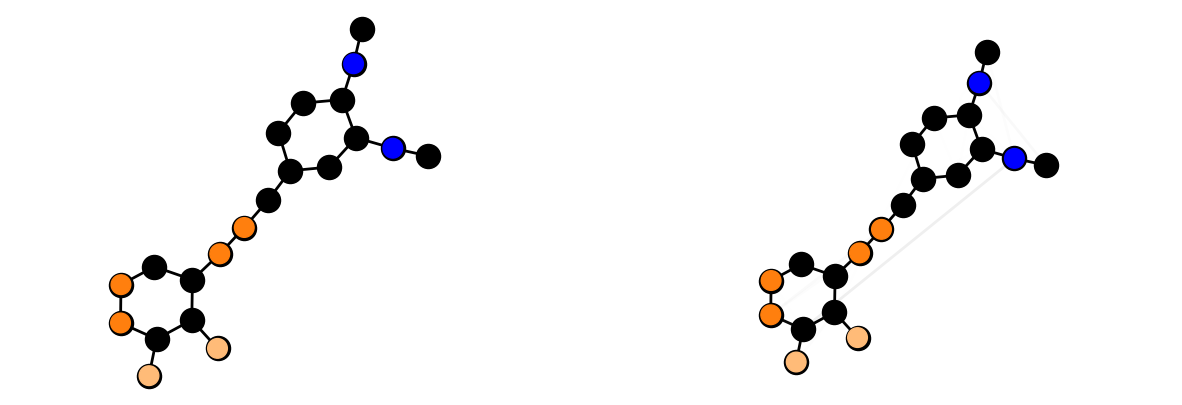

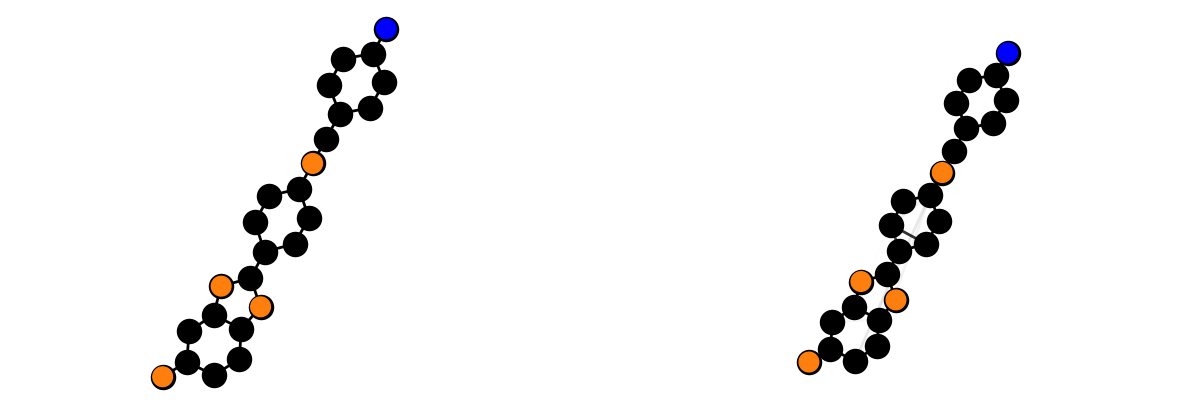

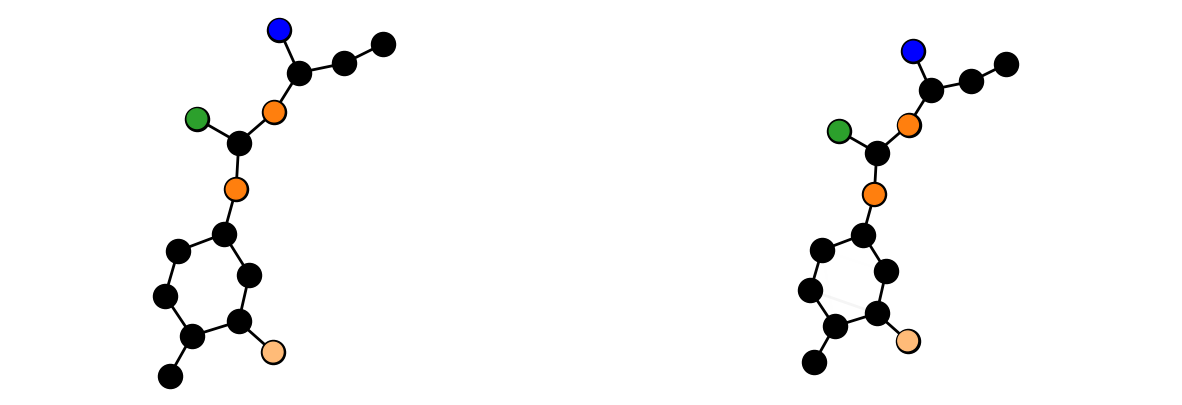

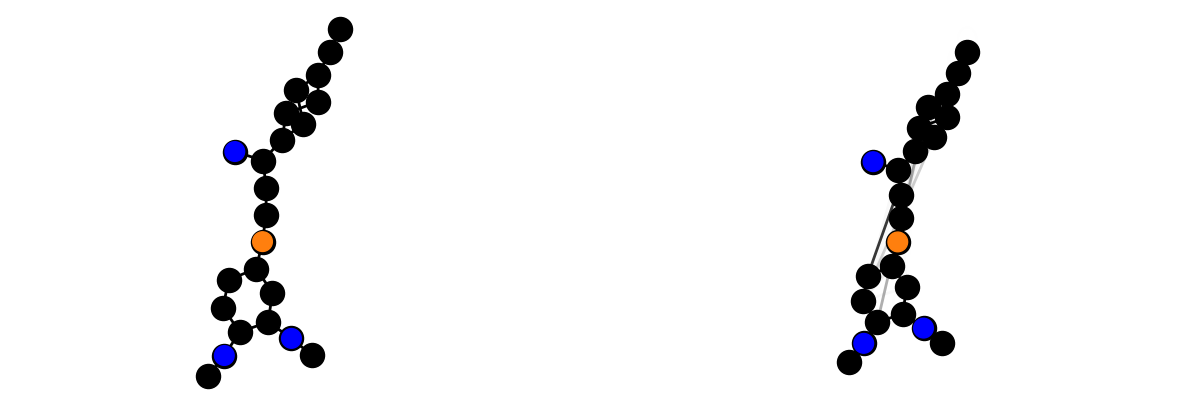

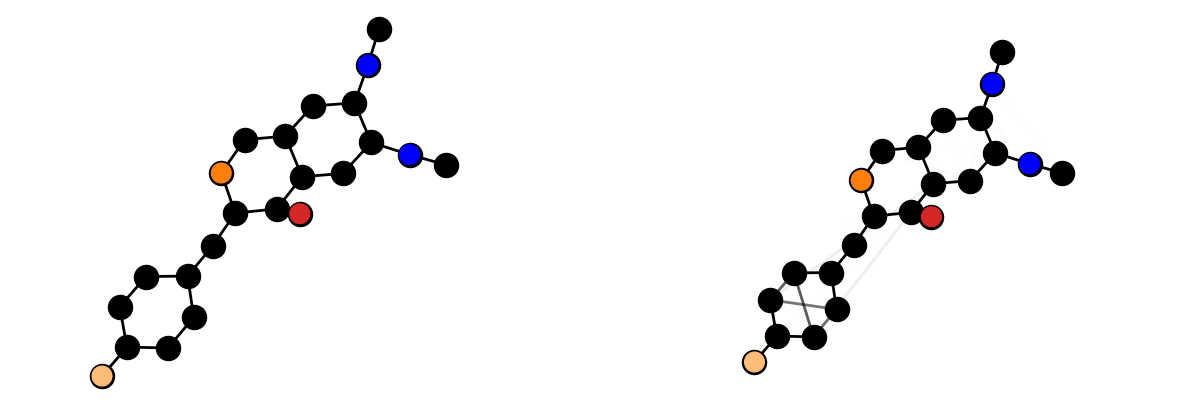

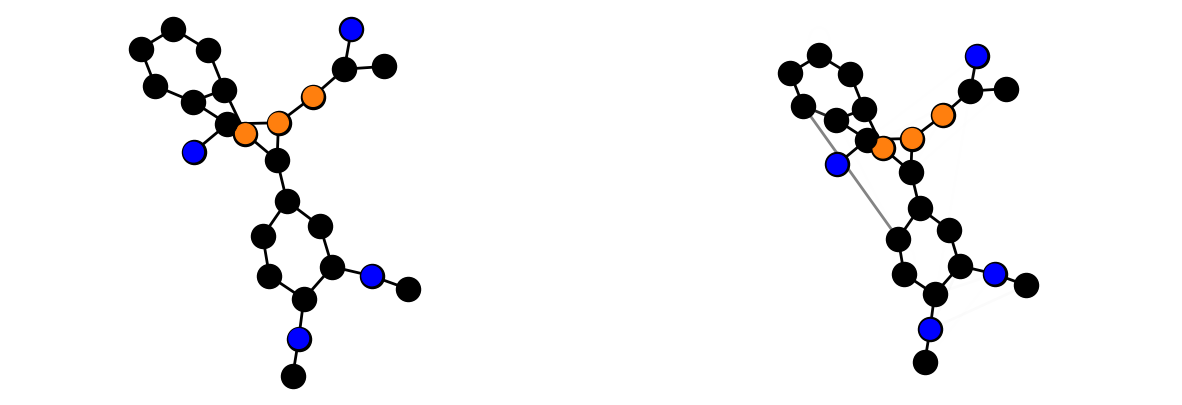

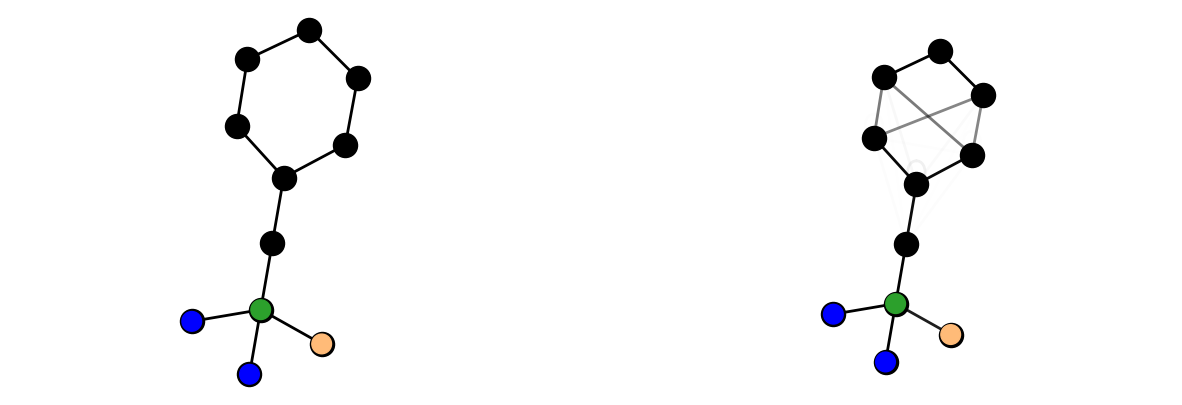

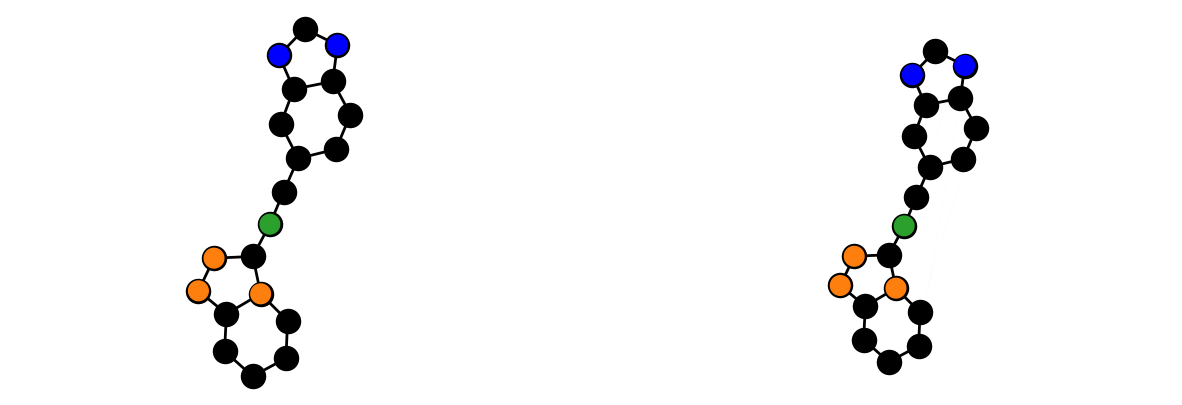

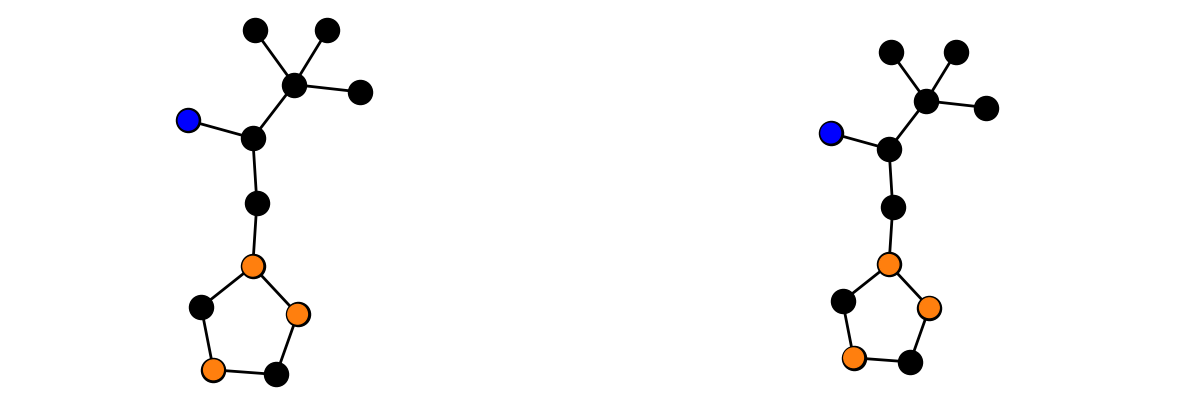

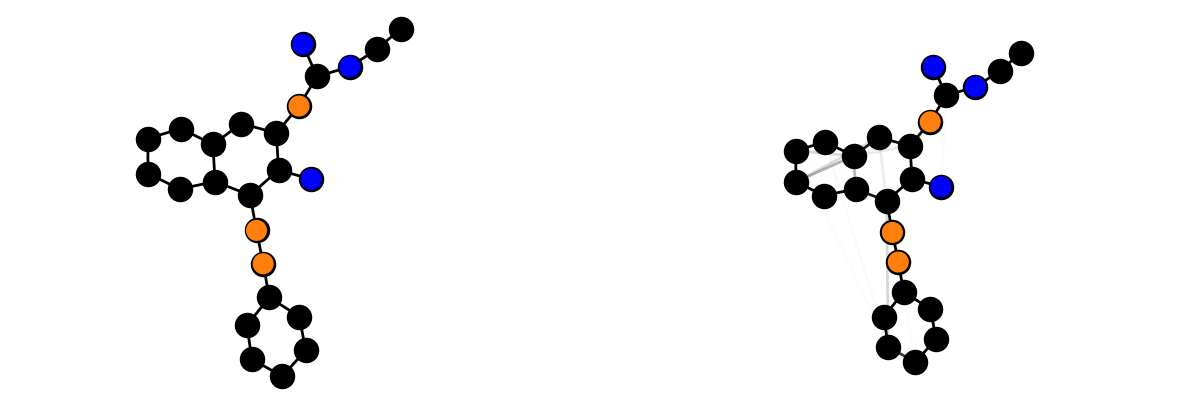

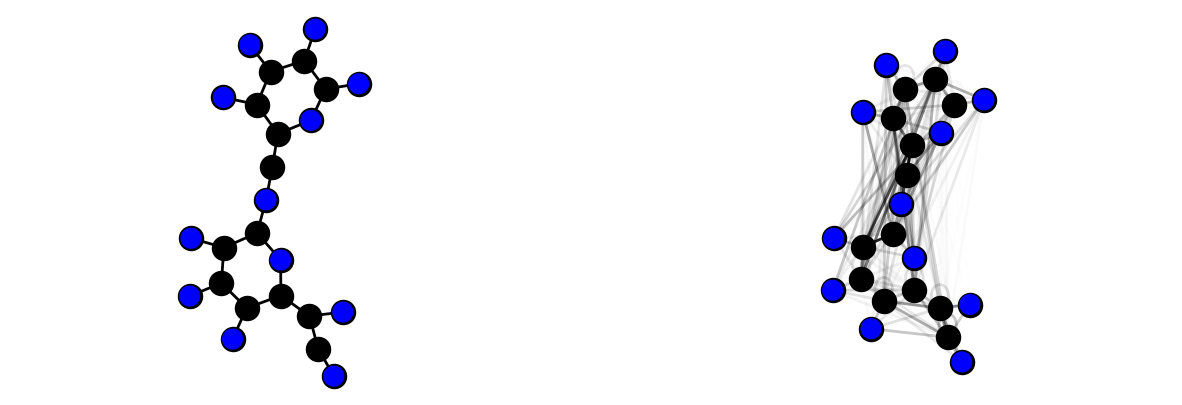

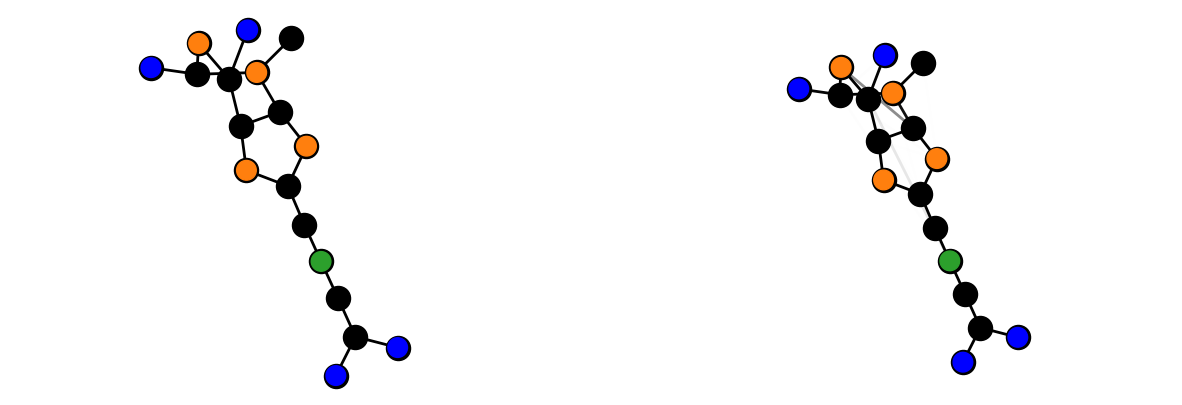

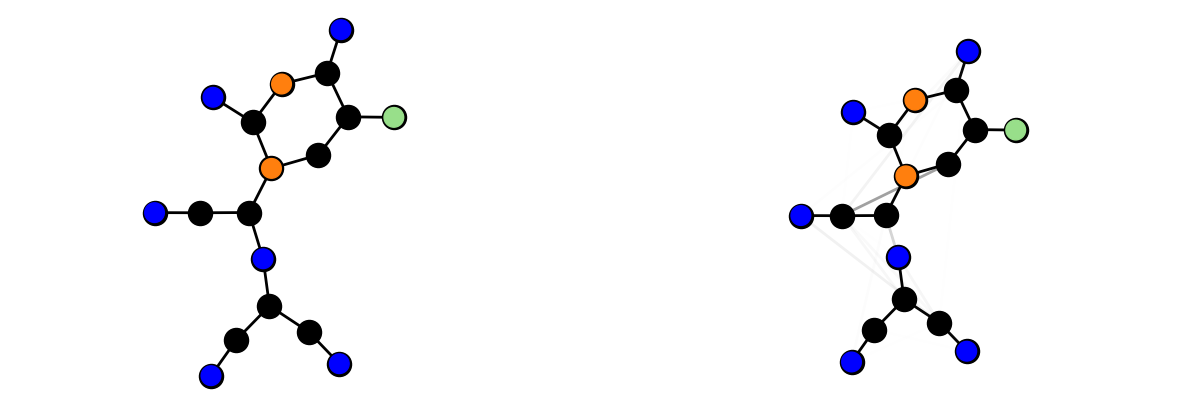

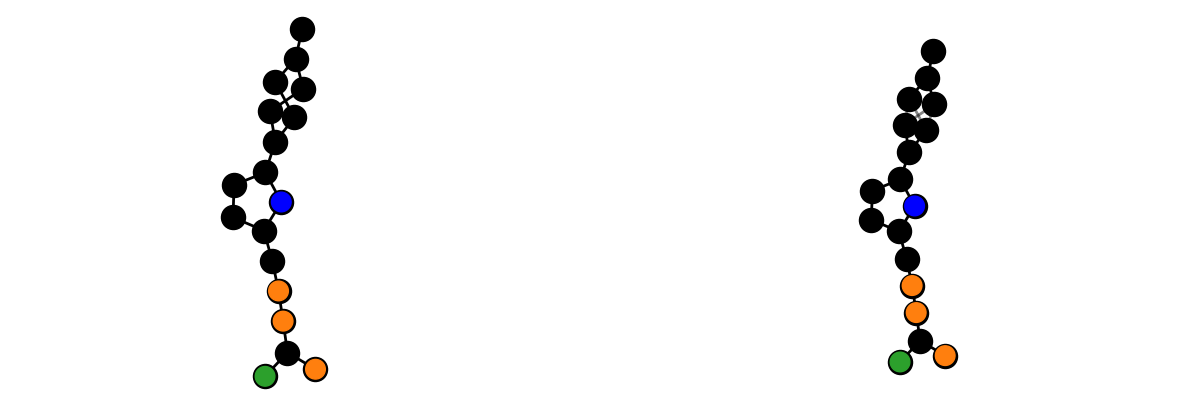

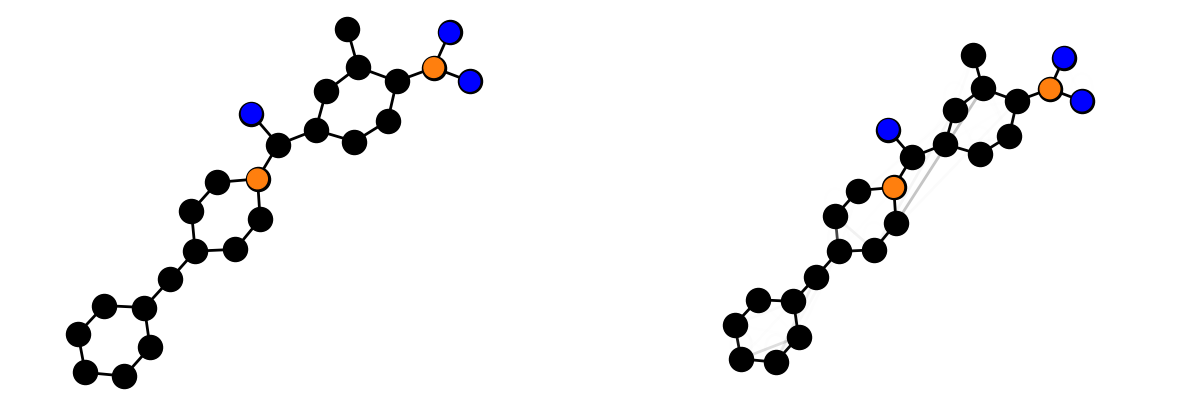

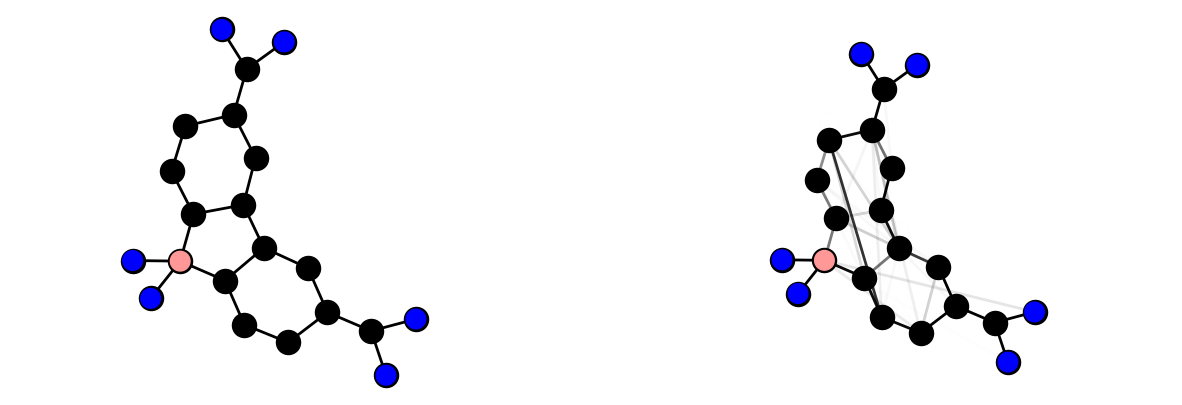

In [24]:
import matplotlib.pyplot as plt
from GRALE.vizualization.plots import plot_graph, atomic_num_colormap

node_size = 200
frame = False
edge_weight = True
hard_permuter = True

loader_val = datamodule.val_dataloader()
for inputs in loader_val:
    inputs = inputs.to('cuda')
    outputs = model(inputs)
    edit, _ = model.validation_metric(outputs, inputs, permutation_matrices=None)
    for k in range(inputs.batchsize):
        h_inputs = inputs.h[k]
        size = int(h_inputs.sum(dim=-1))
        node_labels_inputs = inputs.nodes.labels[k][:size:]
        node_labels_preds = outputs.nodes.labels[k][:size,:]
        A_inputs = inputs.edges.adjacency[k][:size,:size]
        A_preds = outputs.edges.adjacency[k][:size,:size]

        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
        pos = 'kamada'
        pos = plot_graph(node_labels_inputs,A_inputs,ax=ax1,pos=pos,frame=frame,edge_weight=edge_weight)
        plot_graph(node_labels_preds,A_preds,ax=ax2,pos=pos,frame=frame,edge_weight=edge_weight)
        plt.show()
    break

# Plot Reconstructions (Rdkit)

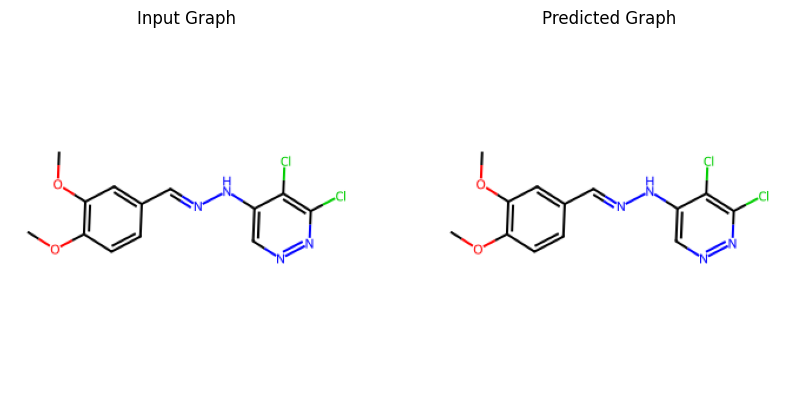

[21:50:11] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[21:50:11] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22


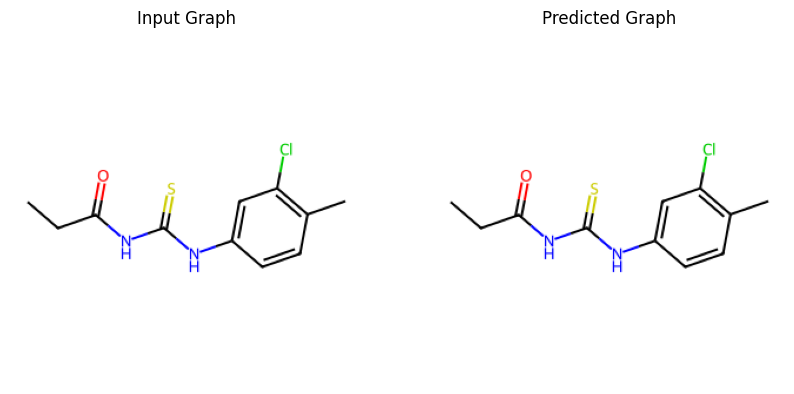

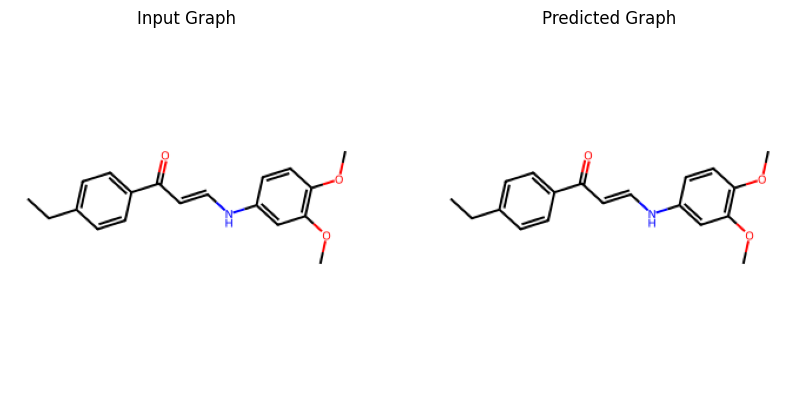

[21:50:11] non-ring atom 13 marked aromatic


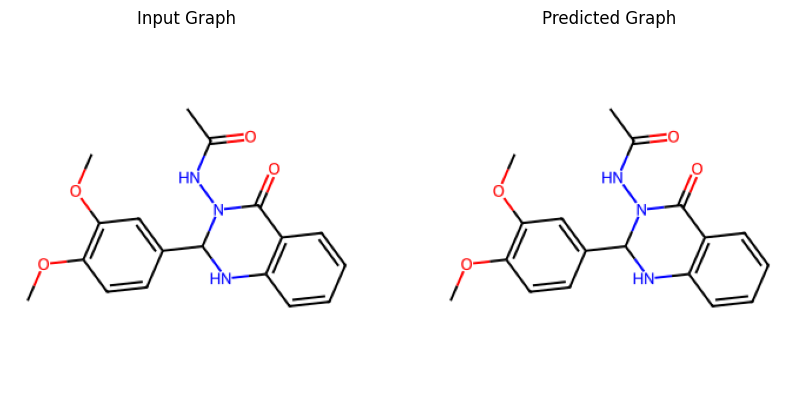

[21:50:11] non-ring atom 0 marked aromatic


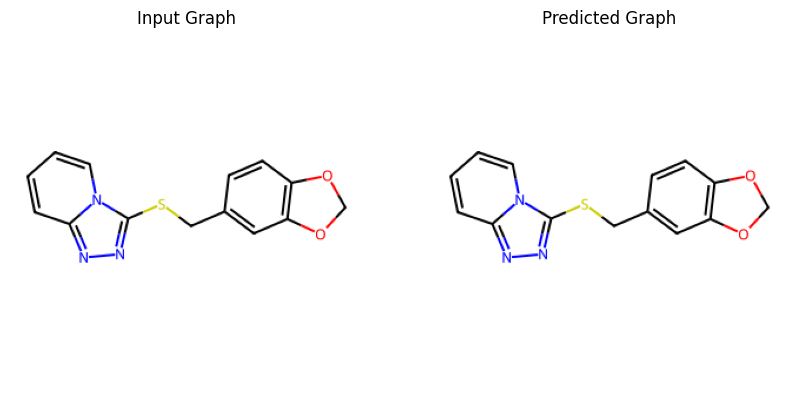

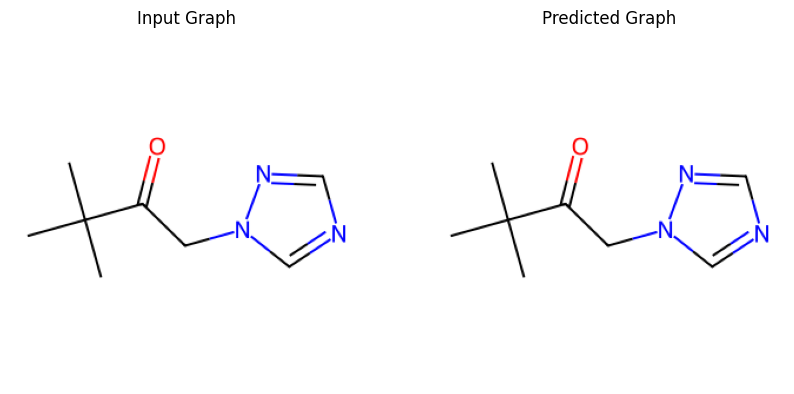

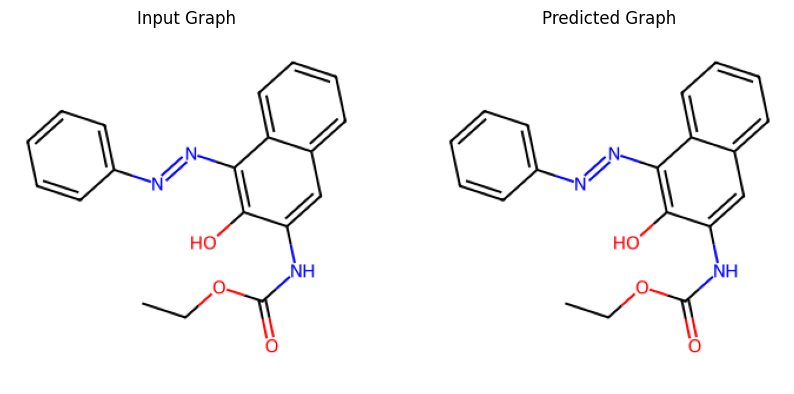

[21:50:12] Explicit valence for atom # 11 O, 3, is greater than permitted
[21:50:12] Can't kekulize mol.  Unkekulized atoms: 2 3 6 9 10 11
[21:50:12] Can't kekulize mol.  Unkekulized atoms: 2 3 6 9 10 11
[21:50:12] Can't kekulize mol.  Unkekulized atoms: 0 1 4
[21:50:12] Can't kekulize mol.  Unkekulized atoms: 0 1 4
[21:50:12] non-ring atom 1 marked aromatic
[21:50:12] Explicit valence for atom # 22 N, 4, is greater than permitted
[21:50:12] Explicit valence for atom # 22 N, 4, is greater than permitted


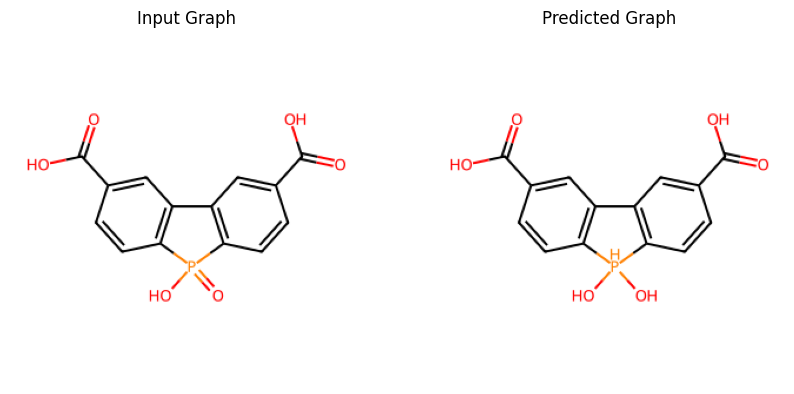

In [8]:
from GRALE.vizualization.plots import graph_to_rdkit
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

loader_val = datamodule.val_dataloader()
for inputs in loader_val:
    inputs = inputs.to('cuda')
    outputs = model(inputs)
    edit, _ = model.validation_metric(outputs, inputs, permutation_matrices=None)
    outputs.edges.labels = 0.5*(outputs.edges.labels + outputs.edges.labels.permute(0,2,1,3)) # symmetrize
    for k in range(inputs.batchsize):
        h_inputs = inputs.h[k]
        size = int(h_inputs.sum(dim=-1))
        node_labels_inputs = inputs.nodes.labels[k][:size:].cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_inputs = inputs.edges.labels[k][:size,:size].cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        node_labels_preds = outputs.nodes.labels[k][:size,:].detach().cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_preds = outputs.edges.labels[k][:size,:size]
        edge_labels_preds = outputs.edges.labels[k][:size,:size].detach().cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        
        smiles_inputs, mol_inputs = graph_to_rdkit(node_labels_inputs, edge_labels_inputs)
        smiles_targets, mol_targets = graph_to_rdkit(node_labels_preds, edge_labels_preds)

        if smiles_inputs is None or smiles_targets is None:
            continue
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            img1 = Draw.MolToImage(mol_inputs, size=(300, 300))
            img2 = Draw.MolToImage(mol_targets, size=(300, 300))
            ax1.imshow(img1)
            ax1.set_title("Input Graph")
            ax1.axis('off')
            ax2.imshow(img2)
            ax2.set_title("Predicted Graph")
            ax2.axis('off')
            plt.show()
    break

In [10]:
from GRALE.vizualization.plots import graph_to_rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

loader_val = datamodule.val_dataloader()
n_total = 0
n_valid_inputs = 0
n_exact_recons = 0
for inputs in loader_val:
    inputs = inputs.to('cuda')
    outputs = model(inputs)
    edit, _ = model.validation_metric(outputs, inputs, permutation_matrices=None)
    outputs.edges.labels = 0.5*(outputs.edges.labels + outputs.edges.labels.permute(0,2,1,3)) # symmetrize
    for k in range(inputs.batchsize):
        h_inputs = inputs.h[k]
        size = int(h_inputs.sum(dim=-1))
        node_labels_inputs = inputs.nodes.labels[k][:size:].cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_inputs = inputs.edges.labels[k][:size,:size].cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        node_labels_preds = outputs.nodes.labels[k][:size,:].detach().cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_preds = outputs.edges.labels[k][:size,:size]
        edge_labels_preds = outputs.edges.labels[k][:size,:size].detach().cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        
        smiles_inputs, mol_inputs = graph_to_rdkit(node_labels_inputs, edge_labels_inputs)
        smiles_targets, mol_targets = graph_to_rdkit(node_labels_preds, edge_labels_preds)
        
        n_total += 1
        if smiles_inputs is None:
            pass
        else:
            n_valid_inputs += 1
            if smiles_inputs == smiles_targets:
                n_exact_recons += 1

print(f"Exact match: {n_exact_recons}/{n_valid_inputs} = {n_exact_recons/n_valid_inputs:.2%}")
print(f"Valid inputs: {n_valid_inputs}/{n_total} = {n_valid_inputs/n_total:.2%}")



Exact match: 456/839 = 54.35%
Valid inputs: 839/1000 = 83.90%


# Graph interpolation in the latent space

In [5]:
from GRALE.vizualization.interpolation import interpolate, get_matrices, interpolate_pos_with_none, plot_graph_interpolation, get_pos_with_none

dataset = datamodule.dataset_valid
idx_start = 0
idx_end = 2
n_timesteps = 128

# Get start and end graphs and interpolate
start = dataset[idx_start]
end = dataset[idx_end]
predictions = interpolate(start, end, model, device ='cuda', n_timesteps=n_timesteps)
# Main trick: the model reconstruction produced graphs that are ordered consistently
start = predictions[0] 
end = predictions[-1]
# Get the positions for the plots
h_start, F_start, A_start = get_matrices(start)
pos_start = get_pos_with_none(h_start, A_start)
h_end, F_end, A_end = get_matrices(end)
pos_end = get_pos_with_none(h_end, A_end)


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 11.72 GiB of which 54.81 MiB is free. Including non-PyTorch memory, this process has 11.65 GiB memory in use. Of the allocated memory 11.42 GiB is allocated by PyTorch, and 34.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

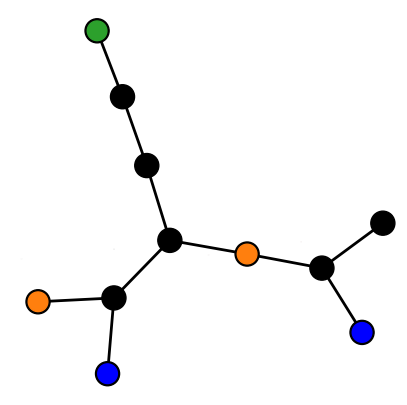

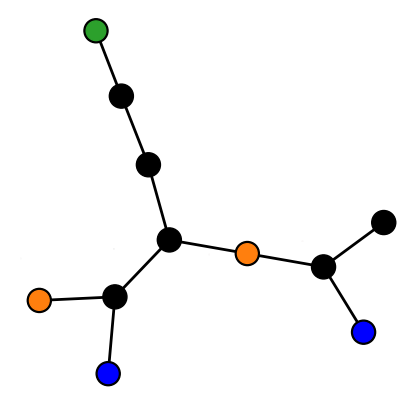

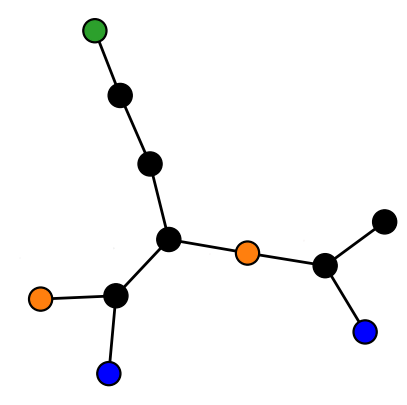

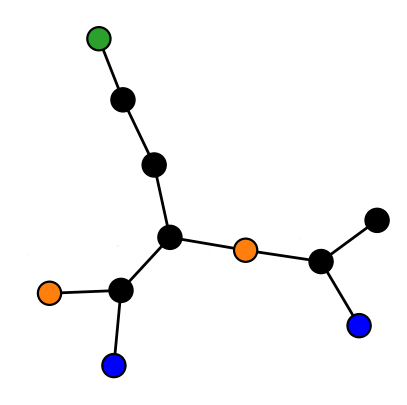

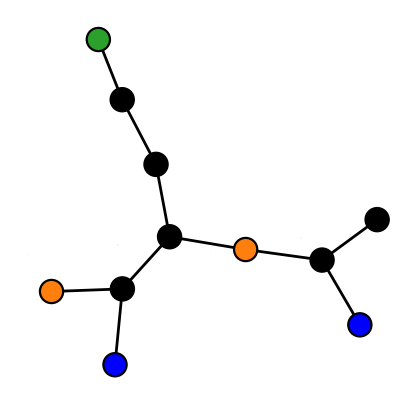

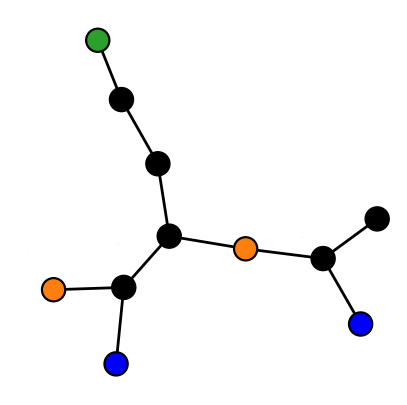

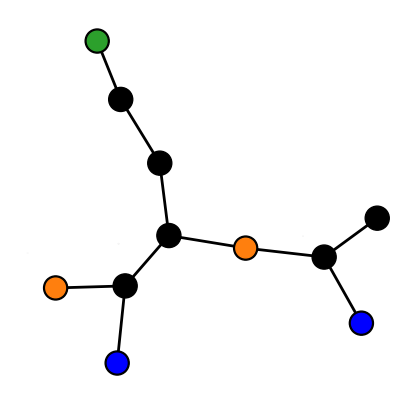

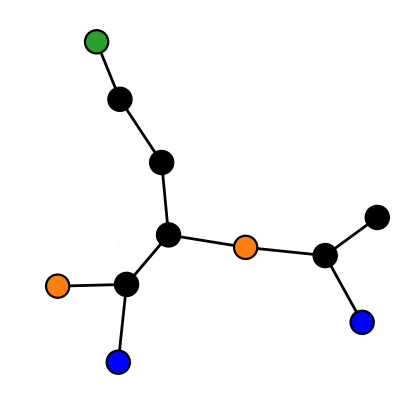

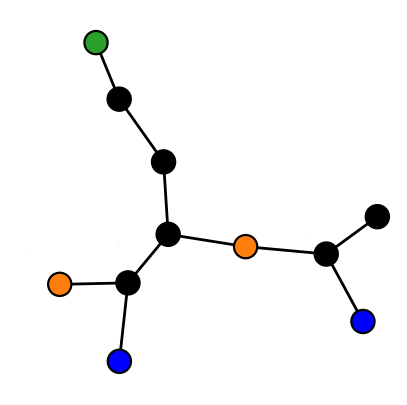

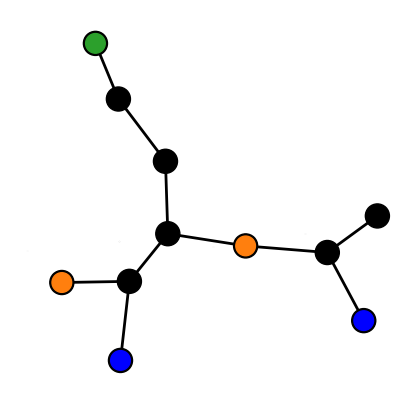

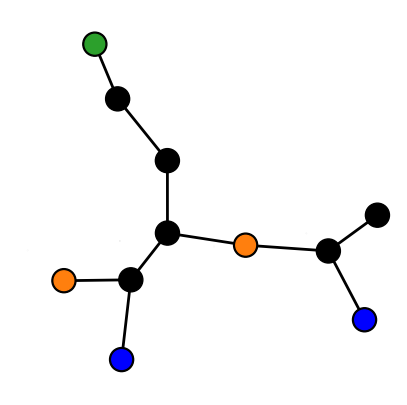

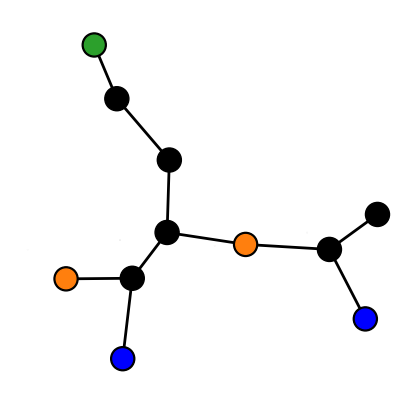

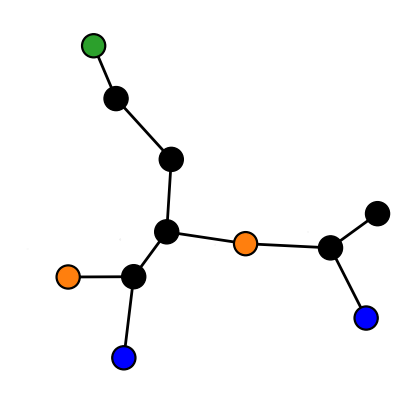

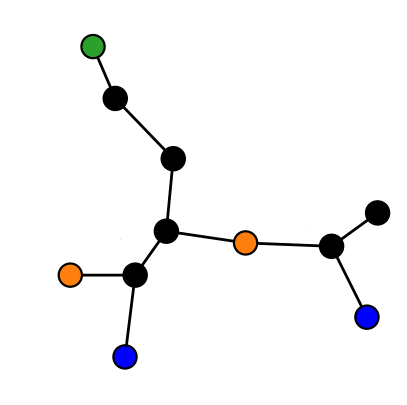

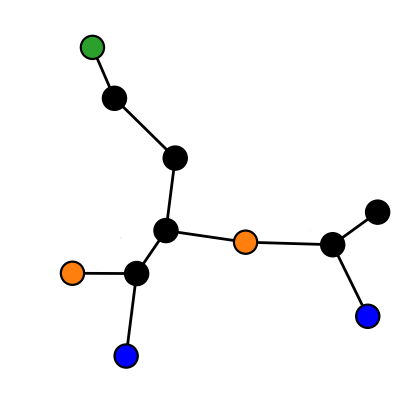

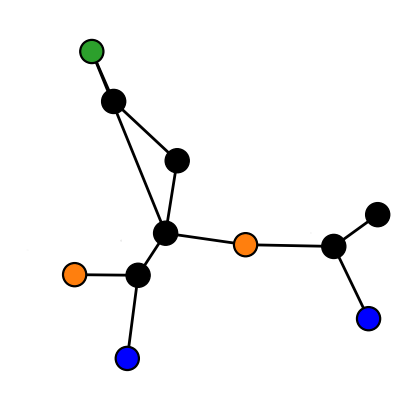

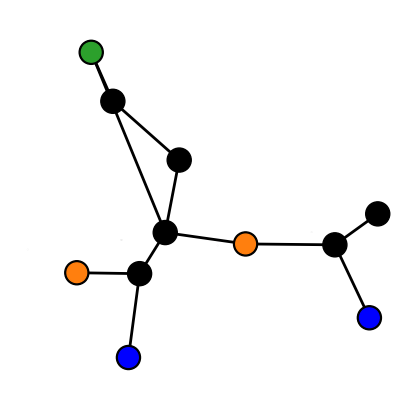

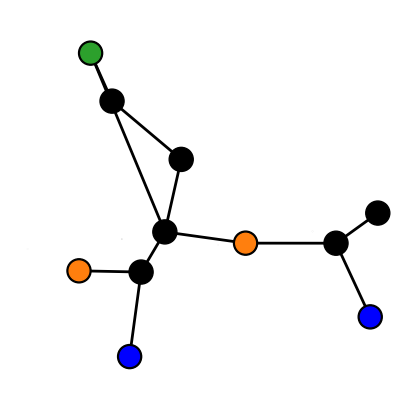

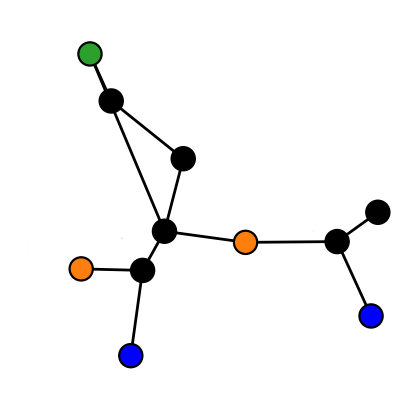

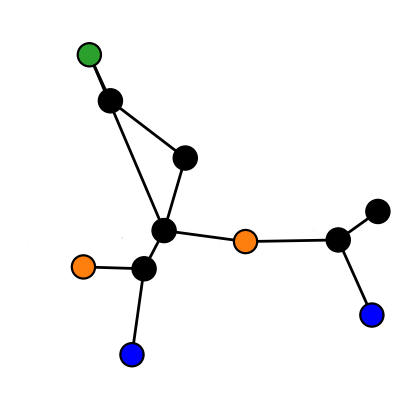

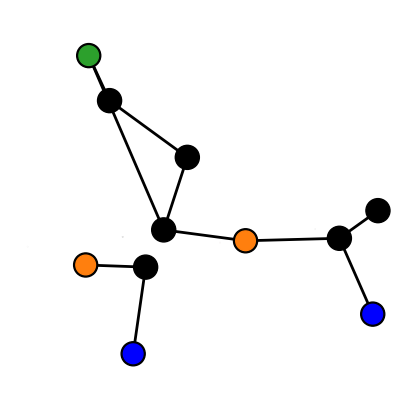

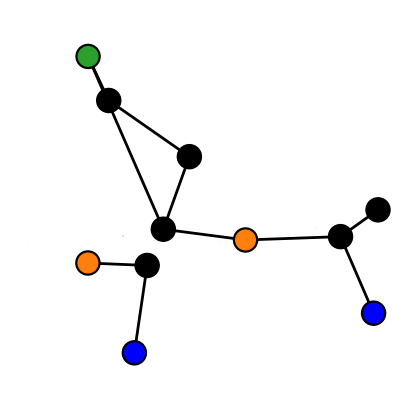

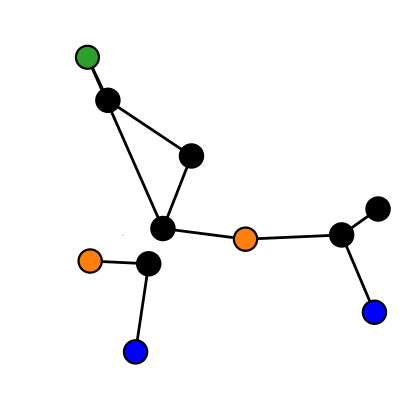

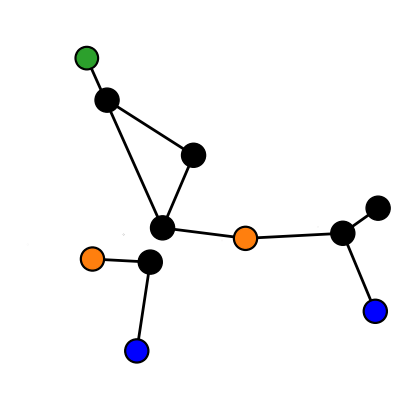

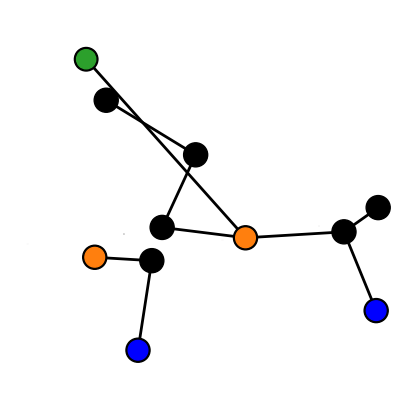

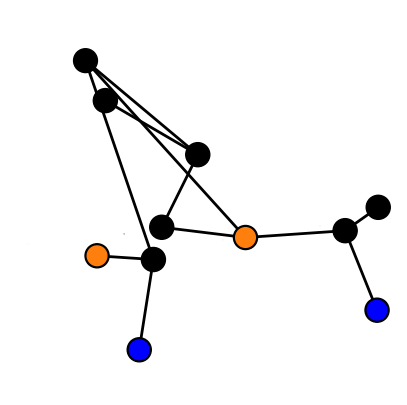

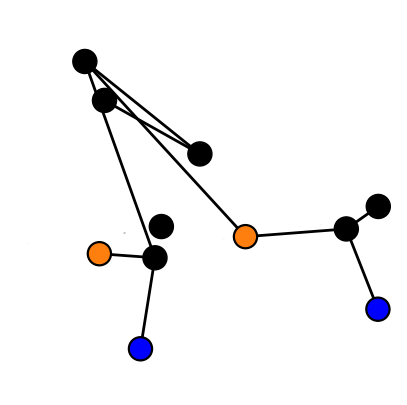

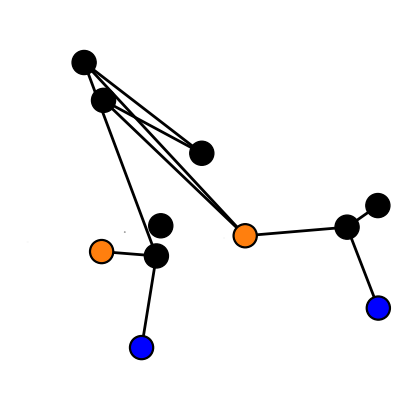

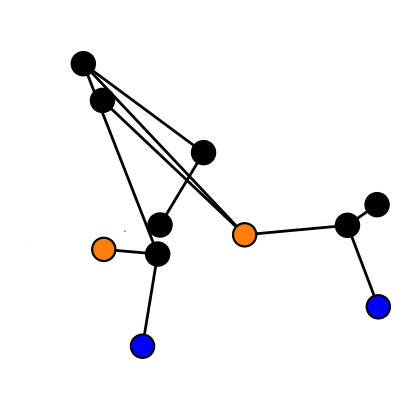

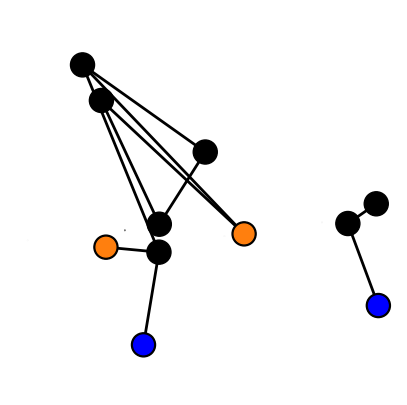

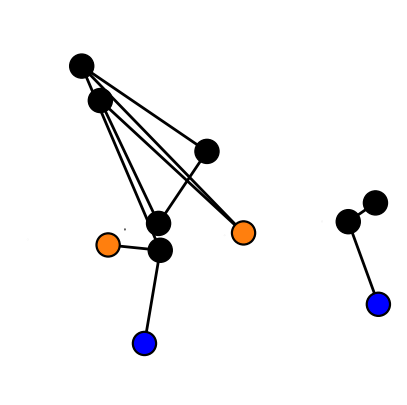

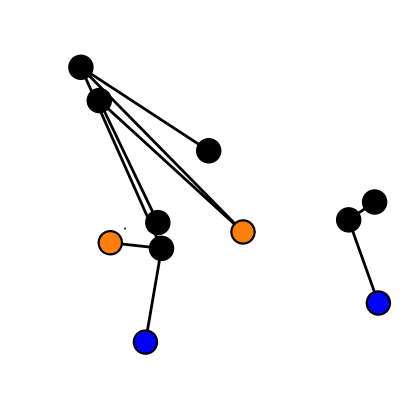

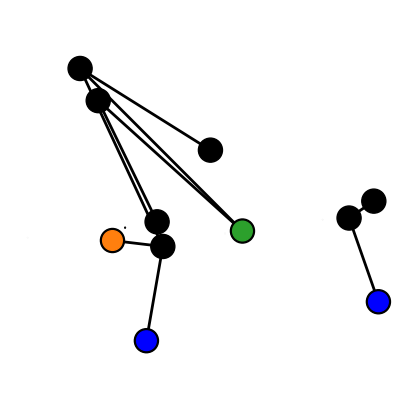

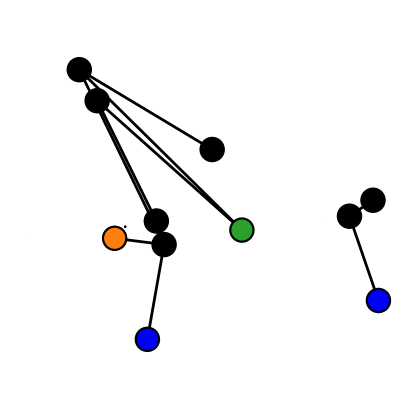

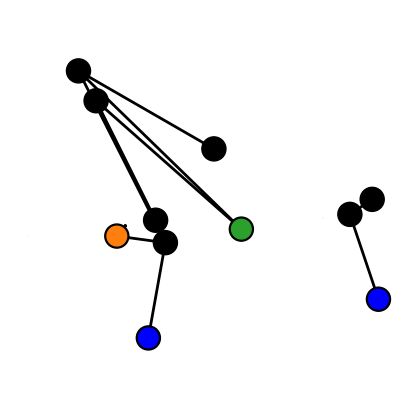

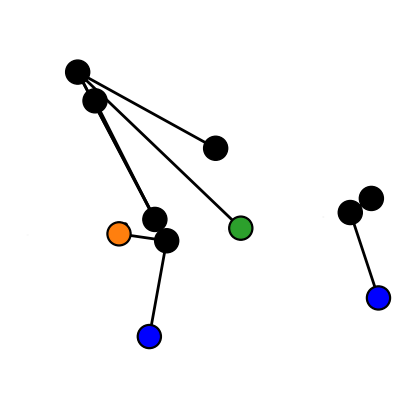

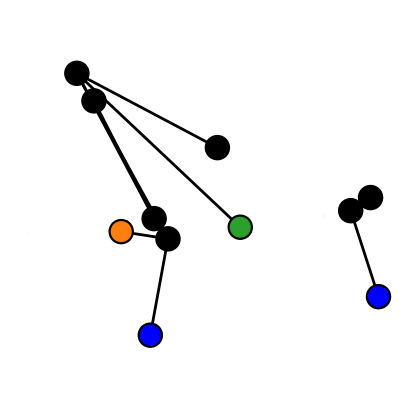

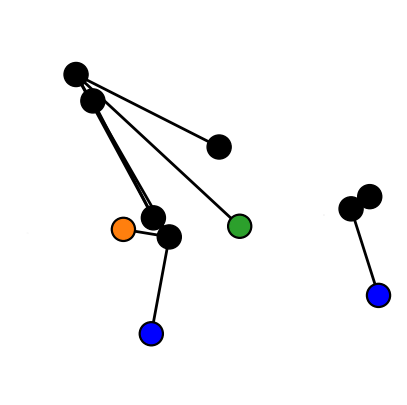

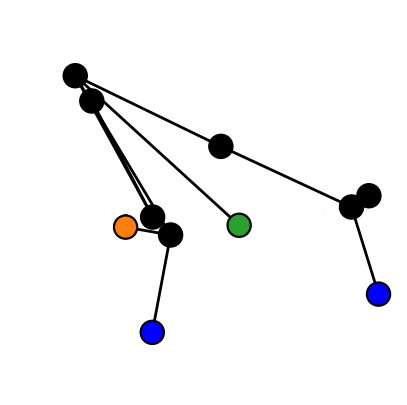

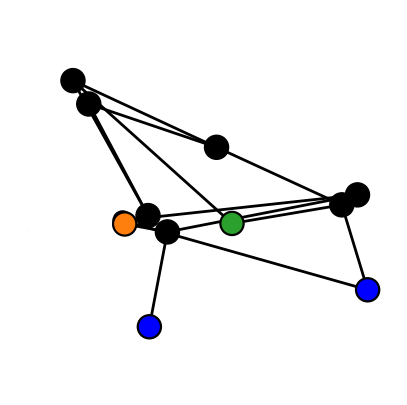

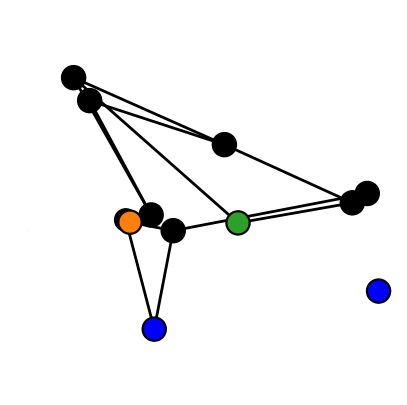

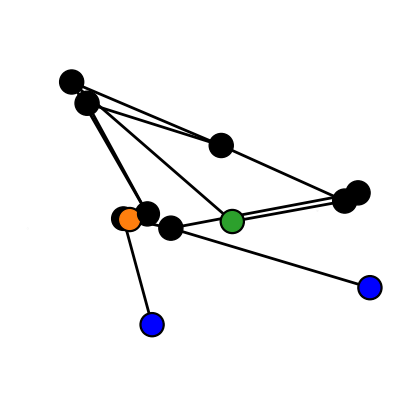

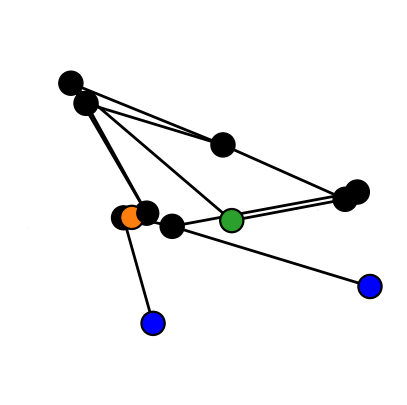

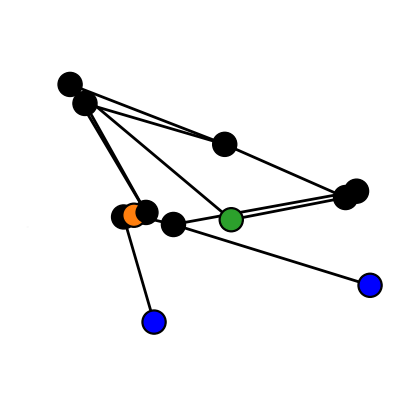

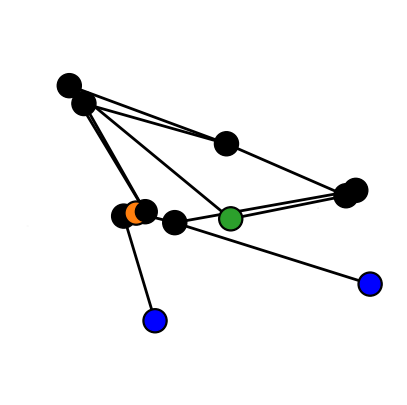

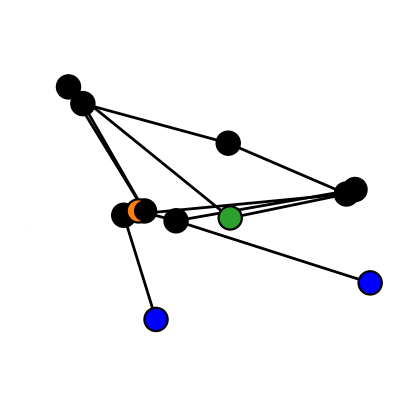

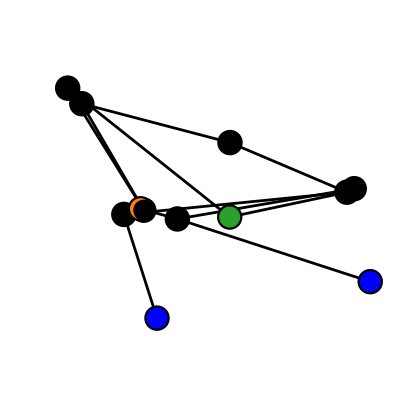

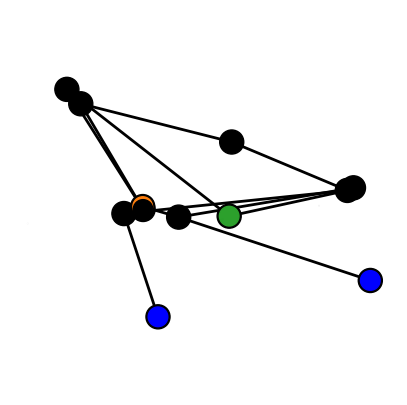

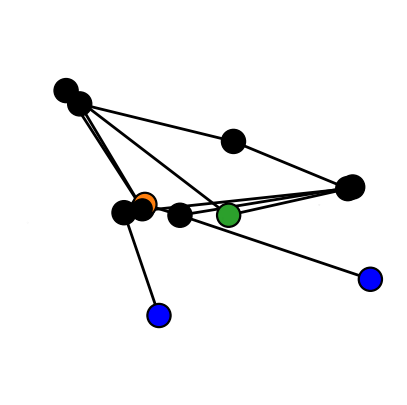

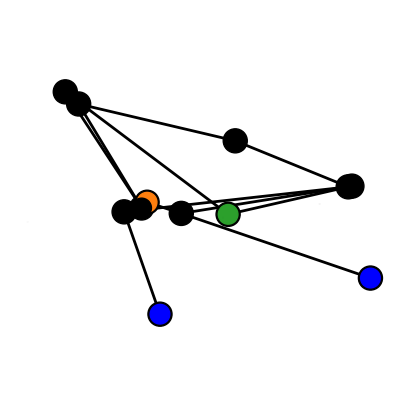

In [ ]:
import matplotlib.pyplot as plt
for t in range(50):
    graph_t = predictions[t]
    h, F, A = get_matrices(graph_t)
    pos = interpolate_pos_with_none(pos_start, pos_end, t/(n_timesteps-1))
    plt.figure(figsize=(5,5))
    plot_graph_interpolation(pos,h,F,A,ax=None,frame=False,edge_weight=False, node_size=200)
    plt.show()